In [716]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import sklearn as sk
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics

In [717]:
# from google.colab import drive
# drive.mount('/content/drive')

# Lectura de datos

In [718]:
# DIR = "/content/drive/MyDrive/Data Mining Properati/"
#df_train = pd.read_csv(DIR + "properati_entrenamiento.zip", index_col="id")  
#df_test = pd.read_csv(DIR + "properati_a_predecir.zip", index_col="id")  
df_test = pd.read_feather('bases/properati_a_predecir.ftr').set_index('id')
df_train = pd.read_feather('bases/properati_entrenamiento.ftr').set_index('id')

# df_test = pd.read_feather(DIR+'properati_a_predecir.ftr').set_index('id')
# df_train = pd.read_feather(DIR+'properati_entrenamiento.ftr').set_index('id')
# df_test.head()

# Entendimiento (magia parte 1 -- AID)

In [719]:
df_test.head()

,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,...,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type
id,,,,,,,,,,,,,,,,,,,,,
556713,Propiedad,2019-11-29,9999-12-31,2019-11-29,-58.442399,-34.573623,Argentina,Capital Federal,Colegiales,None,...,2.0,NaN,NaN,NaN,USD,None,"Departamento en Venta en Belgrano, Capital fed...","Sup total por escritura: 96,47 m2 (cubiertos: ...",Departamento,Venta
192912,Propiedad,2020-06-05,2020-06-08,2020-06-05,-58.430493,-34.606620,Argentina,Capital Federal,Almagro,None,...,2.0,77.0,67.0,NaN,USD,None,Departamento de 3 ambientes en Venta en Almagro,Excelente departamento de tres ambientes ampli...,Departamento,Venta
238224,Propiedad,2020-07-01,9999-12-31,2020-07-01,-58.491760,-34.574123,Argentina,Capital Federal,Villa Urquiza,None,...,1.0,60.0,55.0,NaN,USD,None,Andonaegui 2600 4° - - Departamento en Venta,Excelente 3 ambientes al frente con balcón. Vi...,Departamento,Venta
257134,Propiedad,2019-08-17,9999-12-31,2019-08-17,-58.420737,-34.631770,Argentina,Capital Federal,Boedo,None,...,1.0,74.0,47.0,NaN,USD,None,PH Venta Boedo 2 amb Patio,Corredor Responsable: MARCELO TRUJILLO - CPI ...,PH,Venta
521738,Propiedad,2019-08-05,2019-08-31,2019-08-05,-58.429983,-34.607225,Argentina,Capital Federal,Almagro,None,...,1.0,66.0,64.0,NaN,USD,None,Venta 3 Ambientes - Almagro - Balcón - Ameniti...,Corredor Responsable: Marcelo Trujillo - CUCIC...,Departamento,Venta


In [720]:
prueba = df_test.copy()

prueba.start_date = pd.to_datetime(prueba.start_date)

prueba.loc[prueba.end_date=='9999-12-31','end_date'] = np.nan

prueba.end_date = pd.to_datetime(prueba.end_date)
prueba.created_on = pd.to_datetime(prueba.created_on)

In [721]:
train = df_train.copy()

train.start_date = pd.to_datetime(train.start_date)

train.loc[train.end_date=='9999-12-31','end_date'] = np.nan

train.end_date = pd.to_datetime(train.end_date)
train.created_on = pd.to_datetime(train.created_on)

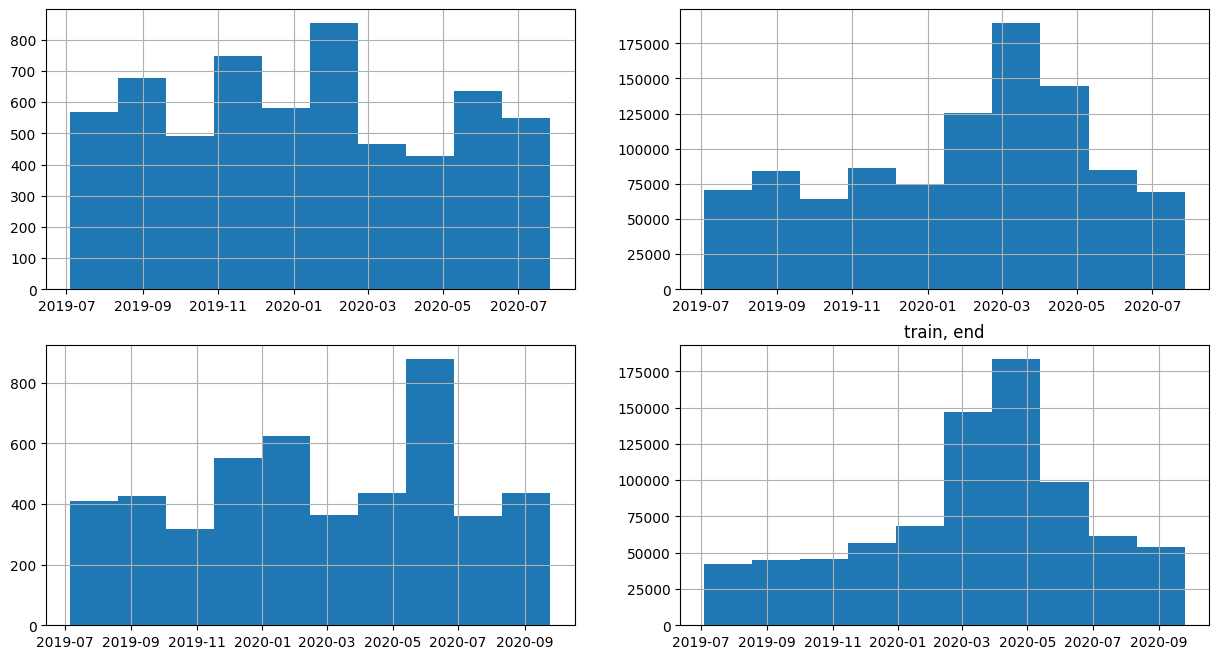

In [722]:
fig, ax = plt.subplots(ncols=2,nrows=2,figsize=(15,8))
prueba.start_date.hist(ax=ax[0,0])
ax[0,0] = plt.title('test, start')
prueba.end_date.hist(ax=ax[1,0])
ax[1,0] = plt.title('test, end')
train.start_date.hist(ax=ax[0,1])
ax[0,1] = plt.title('train, start')
train.end_date.hist(ax=ax[1,1])
ax[1,1] = plt.title('train, end')


# Limpieza y transformación de datos (magia parte 2 -- MD)

In [723]:
raro = df_test['surface_total']<df_test['surface_covered']

df_test.loc[raro,'surface_total'], df_test.loc[raro,'surface_covered'] = df_test.loc[raro,'surface_covered'], df_test.loc[raro,'surface_total']

In [724]:
raro = df_train['surface_total']<df_train['surface_covered']

df_train.loc[raro,'surface_total'], df_train.loc[raro,'surface_covered'] = df_train.loc[raro,'surface_covered'], df_train.loc[raro,'surface_total']

In [725]:
en_amba_train = (df_train.lat>-60)&(df_train['lon']>-35.5)&(df_train['lon']<-34)& (df_train.lat<-56.5) & (df_train.l1=='Argentina')
en_amba_test  =  (df_test.lat>-60)&(df_test['lon']>-35.5)&(df_test['lon']<-34)& (df_test.lat<-56.5) & (df_test.l1=='Argentina')

# en_ballester = ((df_train.title.str.upper().str.contains('BALLESTER')) | (df_train.description.str.upper().str.contains('BALLESTER'))&
#                 en_amba_train)
# ballester = df_train[en_ballester]

no_lugares = ['Bs.As. G.B.A. Zona Sur','Bs.As. G.B.A. Zona Norte','Bs.As. G.B.A. Zona Oeste']

#Filtramos los que se encuentran dentro del rango de AMBA y que no son del conurbano
df_train = df_train[en_amba_train & (~df_train.l2.isin(no_lugares))]

#Pulimos la zona circundante a la plata para que coincida con el test
df_train = df_train[(df_train.l2=='Capital Federal')|((df_train.l2=='Buenos Aires Interior')&(df_train.lat>-58.15)&(df_train.lon<-34.7)&(df_train.lon>-35.1))]

# df_train = pd.concat((df_train,ballester),axis=0)

df_train = df_train[(df_train.price_period=='Mensual')|(df_train.price_period.isnull())] #TODO ver si sacarlo 

df_train.loc[df_train.l2=='Buenos Aires Interior','l2'] = 'Bs.As. G.B.A. Zona Sur'

df_train = df_train[df_train.operation_type=='Venta']

df_test.loc[df_test.title.str.contains('en Las Cañitas'),'l3'] = "Las Cañitas"
df_test.loc[((df_test.l3=='Puerto Madero')|(df_test.l3=='Catalinas')) & (df_test.lat<-58.4),'lat'] = np.nan

df_train.loc[((df_train.l3=='Puerto Madero')|(df_train.l3=='Catalinas')) & (df_train.lat<-58.47),'l3'] = 'Villa Urquiza'
df_train.loc[((df_train.l3=='Puerto Madero')|(df_train.l3=='Catalinas')) & (df_train.lat<-58.44),['lat','lon']] = np.nan

df_train.shape

(152720, 24)

In [726]:
df_test.loc[~en_amba_test,['lat','lon']] = np.nan

In [727]:
cols_a_imputar = ['rooms','bedrooms','bathrooms','surface_total','surface_covered','lat','lon']
# crear nuevas columnas para indicar los valores imputados
for column in cols_a_imputar:
    is_imputed_train = np.where(df_train[column].isnull(), True, False)
    is_imputed_test = np.where(df_test[column].isnull(), True, False)
    df_train[column + '_imputed'] = is_imputed_train
    df_test[column + '_imputed'] = is_imputed_test

In [728]:
#df_train['train_test'] = 'train'
#df_test['train_test'] = 'test'

#df = pd.concat((df_train,df_test),axis=0)

#df.loc[(df.bathrooms.isna())&(df.description.str.contains('(dos|2) baños'))   ,'bathrooms'] = 2
#df.loc[(df.bathrooms.isna())&(df.description.str.contains('(tres|3) baños'))  ,'bathrooms'] = 3
#df.loc[(df.bathrooms.isna())&(df.description.str.contains('(cuatro|4) baños')),'bathrooms'] = 4
#df.loc[(df.bathrooms.isna())&(df.description.str.contains('(cinco|5) baños')) ,'bathrooms'] = 5
#df.loc[(df.bathrooms.isna())&(df.description.str.contains('(seis|6) baños'))  ,'bathrooms'] = 6
#df.loc[(df.bathrooms.isna())&(df.description.str.contains('baño(\ |\.|\,)'))  ,'bathrooms'] = 1

#df_train = df[df.train_test=='train']
#df_test = df[df.train_test=='test']

#df_train.drop(columns='train_test',inplace=True)
#df_test.drop(columns='train_test',inplace=True)

In [729]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [730]:
imp = IterativeImputer(max_iter=10, random_state=42)  # tiene add_indicator

cols_a_imputar = ['rooms','bedrooms','bathrooms', 'surface_total','surface_covered']
df_test[cols_a_imputar] = imp.fit_transform(df_test[cols_a_imputar])
df_train[cols_a_imputar] = imp.fit_transform(df_train[cols_a_imputar])

cols_a_imputar = ['lat','lon']
df_test[cols_a_imputar] = imp.fit_transform(df_test[cols_a_imputar])
df_train[cols_a_imputar] = imp.fit_transform(df_train[cols_a_imputar])

c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [731]:

df_test.rooms      = df_test.rooms.astype('int')
df_train.rooms     = df_train.rooms.astype('int')
df_test.bedrooms   = df_test.bedrooms.astype('int')
df_train.bedrooms  = df_train.bedrooms.astype('int')
df_test.bathrooms  = df_test.bathrooms.astype('int')
df_train.bathrooms = df_train.bathrooms.astype('int')

## Filtrado

In [732]:
pd.concat((df_train.property_type.value_counts(dropna=False),
           df_test.property_type.value_counts(dropna=False)),axis=1).sort_index()

,property_type,property_type
Casa,6878,NaN
Casa de campo,7,NaN
Cochera,2894,NaN
Departamento,97209,5426.0
Depósito,917,NaN
Local comercial,5940,NaN
Lote,8230,NaN
Oficina,4983,NaN
Otro,15649,NaN
PH,10013,574.0


In [733]:
df_train = df_train[df_train.property_type.isin(['PH','Departamento'])]

In [734]:
pd.concat((df_train.bathrooms.value_counts(dropna=False),
           df_test.bathrooms.value_counts(dropna=False)),axis=1)

,bathrooms,bathrooms
1,72464,4605.0
2,23804,1227.0
3,6969,144.0
4,2254,20.0
0,915,NaN
5,633,1.0
6,113,3.0
7,28,NaN
8,12,NaN
11,4,NaN


In [735]:
df_train = df_train[(df_train['bathrooms']<=6) | (df_train['bathrooms'].isnull())]
df_train.shape

(107152, 31)

In [736]:
pd.concat((df_train.currency.value_counts(dropna=False),
           df_test.currency.value_counts(dropna=False)),axis=1)

,currency,currency
USD,102422,6000.0
None,3910,NaN
ARS,820,NaN


In [737]:
df_train = df_train[df_train.currency=='USD'] #saco tambien los nulos porque no tienen precio
df_train.shape

(102422, 31)

In [738]:
pd.concat((df_train.rooms.value_counts(dropna=False),
           df_test.rooms.value_counts(dropna=False)),axis=1).sort_index()

,rooms,rooms
1,20682,NaN
2,30582,2984.0
3,26593,3016.0
4,17756,NaN
5,4668,NaN
6,1264,NaN
7,481,NaN
8,258,NaN
9,46,NaN
10,45,NaN


In [739]:
# df_train = df_train[(df_train.rooms<7) |(df_train.rooms.isnull())]
df_train.shape

(102422, 31)

In [740]:
pd.concat((df_train.bedrooms.value_counts(dropna=False),
           df_test.bedrooms.value_counts(dropna=False)),axis=1).sort_index()

,bedrooms,bedrooms
-1,2,NaN
0,15245,3.0
1,38133,3312.0
2,27821,2660.0
3,16558,23.0
4,3729,1.0
5,507,1.0
6,227,NaN
7,144,NaN
8,22,NaN


In [741]:
# df_train = df_train[(df_train.bedrooms<6) |(df_train.bedrooms.isnull())]
df_train.shape

(102422, 31)

<AxesSubplot: xlabel='surface_covered'>

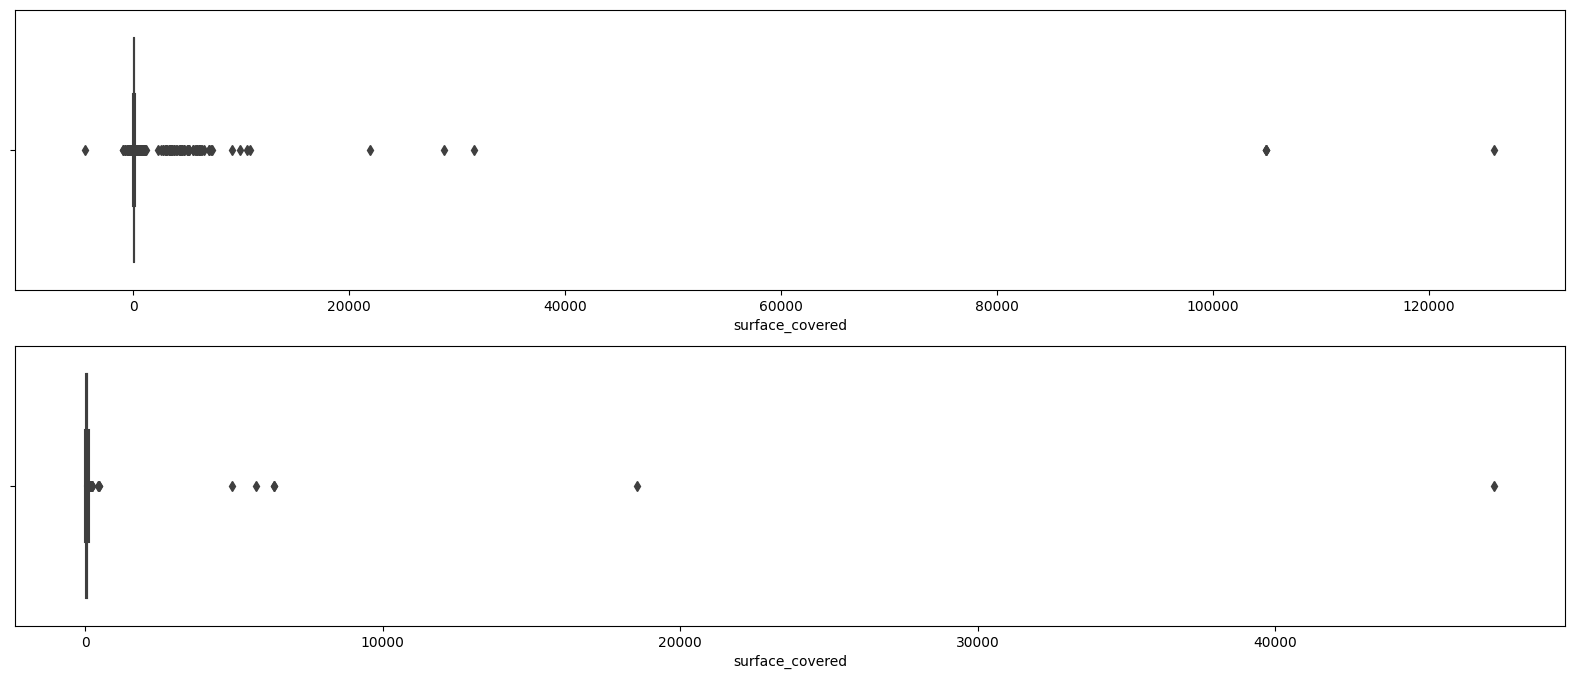

In [742]:
fig, ax = plt.subplots(nrows=2,figsize=(20,8))
sns.boxplot(data=df_train,x='surface_covered',ax=ax[0])
sns.boxplot(data=df_test,x='surface_covered',ax=ax[1])

In [743]:
df_train[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,102422.0,87.192914,720.887917,-4432.263411,41.0,61.0,98.0,126062.0
surface_total,102422.0,138.086412,1024.722444,-149575.086421,43.0,69.0,130.0,126062.0


In [744]:
df_test[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,6000.0,76.894979,672.776879,10.0,45.0,59.000000,76.738295,47360.0
surface_total,6000.0,91.262284,751.427838,21.0,51.0,67.796492,91.032708,47360.0


In [745]:
df_train = df_train[((df_train['surface_covered']>=20)&(df_train['surface_covered']<50000))|(df_train['surface_covered'].isnull())]
df_train.shape

(100591, 31)

<AxesSubplot: xlabel='surface_total'>

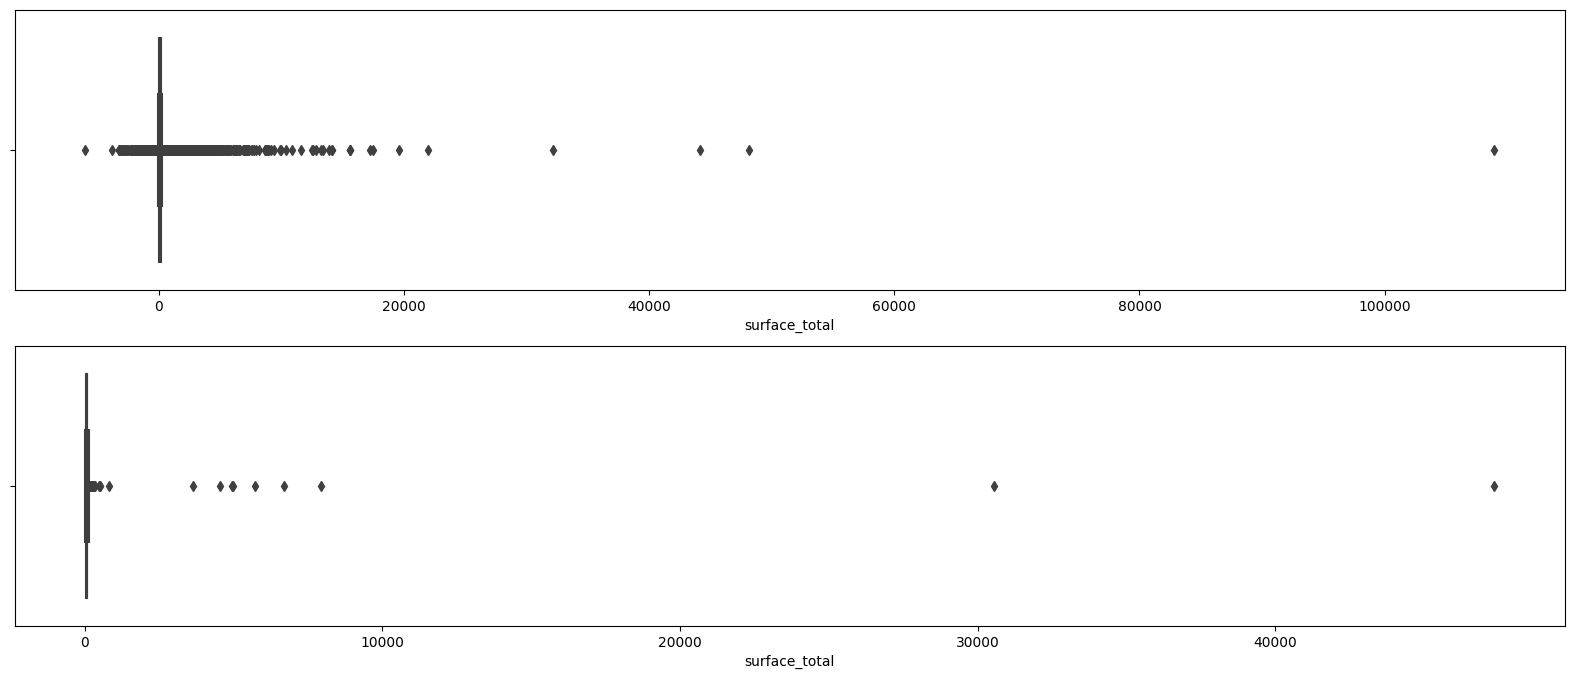

In [746]:
fig, ax = plt.subplots(nrows=2,figsize=(20,8))
sns.boxplot(data=df_train,x='surface_total',ax=ax[0])
sns.boxplot(data=df_test,x='surface_total',ax=ax[1])

In [747]:
df_train[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,100591.0,85.257393,207.768667,20.000000,41.044627,62.0,100.0,31550.0
surface_total,100591.0,146.328567,580.711035,-6008.880032,43.000000,70.0,130.0,108960.0


In [748]:
df_test[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,6000.0,76.894979,672.776879,10.0,45.0,59.000000,76.738295,47360.0
surface_total,6000.0,91.262284,751.427838,21.0,51.0,67.796492,91.032708,47360.0


In [749]:
df_train = df_train[((df_train['surface_total']>=10)&(df_train['surface_total']<50000))|(df_train['surface_total'].isnull())]
df_train.shape

(95914, 31)

In [750]:
df_train[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,95914.0,82.577618,212.001841,20.0,41.0,60.0,91.0,31550.0
surface_total,95914.0,169.079044,457.650534,12.0,46.0,73.0,138.0,48170.0


In [751]:
df_test[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,6000.0,76.894979,672.776879,10.0,45.0,59.000000,76.738295,47360.0
surface_total,6000.0,91.262284,751.427838,21.0,51.0,67.796492,91.032708,47360.0


In [752]:
df_train.price.value_counts().sort_index()

5000.0        1
9500.0        1
10000.0       5
10500.0       2
11111.0       1
             ..
9477000.0     3
11111111.0    1
12345678.0    1
15011160.0    1
32434232.0    1
Name: price, Length: 6371, dtype: int64

## Imputación de nulos

## Armado de variables

In [753]:
df = pd.concat((df_train,df_test),axis=0)

df['bathrooms_rooms'] = df['bathrooms']/df['rooms']
df['bedrooms_rooms'] = df['bedrooms']/df['rooms']
df['covered'] = df['surface_covered']/df['surface_total']

df['start_year']  = pd.to_datetime(df['start_date']).dt.year
df['start_month'] = pd.to_datetime(df['start_date']).dt.month
df['start_day'] = pd.to_datetime(df['start_date']).dt.month

df['tiene_esp_abierto'] = 0
df.loc[(df['surface_total']-df['surface_covered'])!=0,'tiene_esp_abierto'] = 1

df['description'] = df["description"].str.lower().str.replace('á','a').str.replace('é','e').str.replace('í','i').str.replace('ó','o').str.replace('ú','u')
#df['title'] = df["title"].str.lower().str.replace('á','a').str.replace('é','e').str.replace('í','i').str.replace('ó','o').str.replace('ú','u')

for c in ["barrio privado", "corredor",'suite','monoambiente','amueblado',
          'ascensor','parrilla','patio','balcon','jardin','linea (a|b|b|c|d|e|h)',
          'obelisco','catedral','metrobus','barrancas','barrio chino','river',
          'universidad','facultad','subte','tren','estacion','museo','parque','jacuzzi',
          '(j|y)acu(z|zz)i','sho(pp|p)ing','country','terminal','avenida','av.','av',
          'expensa','expensas','a(mm|m)enities','inmobiliaria','dueñ(o|a) direct(o|a)',
          'balcon','pileta|piscina','escuela|colegio','centro','microcentro','lago']:
    df[f"desc_{c}"] = df["description"].str.contains(c,regex=True)
    #df[f"title_{c}"] = df["title"].str.contains(c,regex=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_8936\2937259013.py:24: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df[f"desc_{c}"] = df["description"].str.contains(c,regex=True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_8936\2937259013.py:24: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df[f"desc_{c}"] = df["description"].str.contains(c,regex=True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_8936\2937259013.py:24: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df[f"desc_{c}"] = df["description"].str.contains(c,regex=True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_8936\2937259013.py:24: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extrac

In [754]:
df.covered.value_counts(dropna=False).sort_index()

0.000851     1
0.004233     1
0.004679     1
0.005105     1
0.007350     1
            ..
19.352209    2
20.143609    1
21.003826    2
24.100608    1
26.738608    1
Name: covered, Length: 5677, dtype: int64

In [755]:
df_train = df[~df.price.isnull()]
df_test = df[df.price.isnull()]

## Selección de atributos

In [756]:
cols = ['l1','l5','l6','ad_type','currency','operation_type']
df_train.drop(cols,inplace=True,axis=1)
df_test.drop(cols,inplace=True,axis=1)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_8936\2438721469.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(cols,inplace=True,axis=1)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_8936\2438721469.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(cols,inplace=True,axis=1)


## Dummies

In [757]:
cols_dummies = ['l2','l3','l4','property_type']
train_dummies = pd.get_dummies(df_train[cols_dummies],dummy_na=True)
df_train = pd.concat((df_train,train_dummies),axis=1)

test_dummies = pd.get_dummies(df_test[cols_dummies],dummy_na=True)
df_test = pd.concat((df_test,test_dummies),axis=1)

In [758]:
cols = pd.concat((df_train,df_test),axis=0,join='inner').columns

df_train = df_train[cols]
df_test = df_test[cols]

## Borrado por varianza

In [759]:
from sklearn.feature_selection import VarianceThreshold

In [760]:
# F = df_train[~df_train.price.isnull()]
# X = F[F.select_dtypes(include=['float64' ,'float32','int64', 'int32', 'int16', 'int8', 'bool','uint8']).columns.drop('price')]
# y = F['price']

# print(X.shape)
# fs = VarianceThreshold(threshold=0.005)
# X_new = fs.fit_transform(X) # threshold = limite superior de la varianza
# print(X_new.shape)

# cols = list(X.columns[fs.get_support()])
# cols.append('price')

# df_train = df_train[cols]
# df_test = df_test[cols]

In [761]:
df_train.loc[((df_train.l3=='Puerto Madero')|(df_train.l3=='Catalinas'))&(df_train.lat<-58.42),'lat'] = -58.361

In [762]:
df_test.loc[((df_test.l3=='Puerto Madero')|(df_test.l3=='Catalinas'))&(df_test.lat<-58.4),'lat'] = -58.361

<AxesSubplot: xlabel='lat', ylabel='lon'>

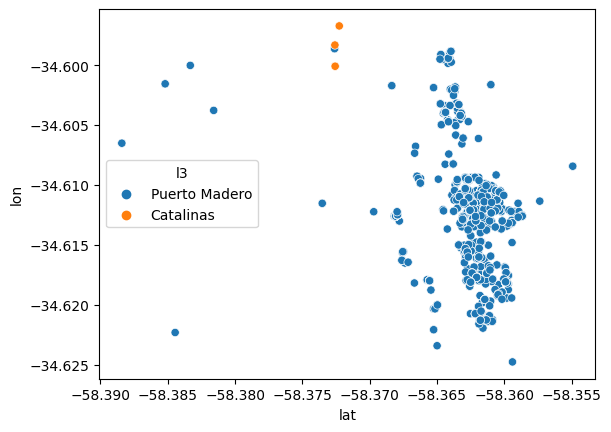

In [763]:
sns.scatterplot(data=df_train[(df_train.l3=='Puerto Madero')|(df_train.l3=='Catalinas')],x='lat',y='lon',hue='l3')

In [764]:
df_test_la_plata = df_test[(df_test.lat>-58.2)&(df_test.lon<-34.8)]
df_train_la_plata = df_train[(df_train.lat>-58.2)&(df_train.lon<-34)]

df_test_caba = df_test[(df_test.lat<=-58.2)&(df_test.lon>=-34.8)&~((df_test.l3=='Puerto Madero')|(df_test.l3=='Catalinas'))]
df_test_madero = df_test[(df_test.lat<=-58.2)&(df_test.lon>=-34.8)&((df_test.l3=='Puerto Madero')|(df_test.l3=='Catalinas'))]
df_train_caba = df_train[~((df_train.lat>-58.2)&(df_train.lon<-34))&~((df_train.l3=='Puerto Madero')|(df_train.l3=='Catalinas'))]
df_train_madero = df_train[~((df_train.lat>-58.2)&(df_train.lon<-34))&((df_train.l3=='Puerto Madero')|(df_train.l3=='Catalinas'))]


In [765]:
def filtrado_columnas(df_test,df_train):
    F = df_train[~df_train.price.isnull()]
    X = F[F.select_dtypes(include=['float64' ,'float32','int64', 'int32', 'int16', 'int8', 'bool','uint8']).columns.drop('price')]
    y = F['price']

    clf = sk.ensemble.RandomForestRegressor(n_estimators=50, n_jobs=-1,random_state=42)
    clf.fit(X, y)

    importancias = pd.DataFrame({'atributo': clf.feature_names_in_, 'importancia': clf.feature_importances_})
    cols = list(importancias[importancias['importancia']>0.0001].sort_values('importancia',ascending=False).reset_index(drop=True).atributo)

    cols.append('price')

    display(importancias.sort_values('importancia'))

    df_train = df_train[cols]
    df_test = df_test[cols]
    return df_test, df_train

In [766]:
# Funcion de limpieza (usada en la siguiente sección) que usa y_train
def limpiar_fold(X_train, y_train, X_test):
    ## TODO: limpiar los datos

    return (X_train, y_train, X_test)

# Entrenamiento del modelo

## Territorio de Aprendizaje Automático
☢☢☢☢☢☢ Se mira y no se toca ☢☢☢☢☢☢☢

### La Plata

In [767]:
df_test_la_plata, df_train_la_plata = filtrado_columnas(df_test_la_plata,df_train_la_plata)

,atributo,importancia
65,l2_nan,0.000000
94,l3_Parque Centenario,0.000000
93,l3_Parque Avellaneda,0.000000
92,l3_Palermo,0.000000
91,l3_Once,0.000000
...,...,...
5,surface_total,0.053908
19,start_day,0.056989
1,lon,0.088047
2,rooms,0.106677


In [768]:
df_train = df_train_la_plata.copy()

# Datos para probar
df_train = df_train.select_dtypes(include=['float64', 'int64', 'int32', 'int16', 'int8', 'bool'])

X = df_train[df_train.columns.drop('price')]
y = df_train['price']

In [769]:
# Creamos el modelo
reg = sk.ensemble.RandomForestRegressor(n_estimators=500, max_depth=5, n_jobs=-1, random_state=42)

# Partimos en entrenamiento+prueba y validación
X_train_test, X_val, y_train_test, y_val = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

scores_train = []
scores_test = []
# Validación cruzada, 10 folds, shuffle antes
kf = sk.model_selection.KFold(n_splits=10, shuffle=True, random_state=42)
for fold, (train_index, test_index) in enumerate(kf.split(X_train_test, y_train_test)):
    X_train, X_test, y_train, y_test = X_train_test.iloc[train_index], X_train_test.iloc[test_index], y_train_test.iloc[train_index], y_train_test.iloc[test_index]

    X_train, y_train, X_test = limpiar_fold(X_train, y_train, X_test)

    # Entrenamos el modelo
    reg.fit(X_train, y_train)

    # Predecimos en train
    y_pred = reg.predict(X_train)

    # Medimos la performance de la predicción en test
    score_train = sk.metrics.mean_squared_error(y_train, y_pred)
    scores_train.append(score_train)

    # Predecimos en test
    y_pred = reg.predict(X_test)    

    # Medimos la performance de la predicción en test
    score_test = sk.metrics.mean_squared_error(y_test, y_pred)
    scores_test.append(score_test)
    
    print(f"{fold=}, {score_train=} {score_test=}")
    

print(f"Train scores mean={pd.Series(scores_train).mean()}, std={pd.Series(scores_train).std()}")
print(f"Test scores mean={pd.Series(scores_test).mean()}, std={pd.Series(scores_test).std()}")

fold=0, score_train=71057442.98238891 score_test=2544963800.6185913
fold=1, score_train=92296299.79821949 score_test=104973634.10516052
fold=2, score_train=108675687.04301603 score_test=547982124.3568027
fold=3, score_train=96944558.11868683 score_test=726858111.451972
fold=4, score_train=91732597.257481 score_test=295272026.0740694
fold=5, score_train=87153188.47871496 score_test=784238133.2482708
fold=6, score_train=99543956.97159794 score_test=673104942.4394323
fold=7, score_train=106463939.14041483 score_test=71124648.32727548
fold=8, score_train=110810943.56253973 score_test=84019612.50781764
fold=9, score_train=97250667.00532101 score_test=286812900.69971806
Train scores mean=96192928.03583807, std=11721301.768457321
Test scores mean=611934993.382911, std=731929558.3366078


#### Predicción para kaggle


In [770]:
df_test = df_test_la_plata.copy()

## Datos a predecir 
X = df_train[df_train.columns.drop('price')]
y = df_train['price']
X_prueba = df_test[df_train.columns.drop('price')] # cuidado:

# Entrenamos el modelo con todos los datos
reg.fit(X, y)

# Predecimos
df_test['price'] = reg.predict(X_prueba)

# Grabamos
# df_test['price'].to_csv('solucion_la_plata.csv', index=True)

solucion_la_plata = df_test['price']

In [771]:
pd.DataFrame(zip(df_train.columns.drop('price'), reg.feature_importances_*100), columns=["column", "feature_importance"]).sort_values(by="feature_importance", ascending=False).head(10)

,column,feature_importance
0,surface_covered,33.649296
1,rooms,10.036678
4,surface_total,7.809845
2,lon,7.688251
8,start_month,6.513865
3,start_day,4.946746
5,bedrooms,3.825807
10,surface_covered_imputed,3.760644
6,desc_parrilla,3.757008
11,lat,2.858100


### CABA

In [772]:
df_test_caba, df_train_caba = filtrado_columnas(df_test_caba,df_train_caba)

,atributo,importancia
65,l2_nan,0.000000
100,l3_Puerto Madero,0.000000
76,l3_Catalinas,0.000000
64,l2_Capital Federal,0.000000
63,l2_Bs.As. G.B.A. Zona Sur,0.000000
...,...,...
5,surface_total,0.043241
0,lat,0.054040
11,surface_covered_imputed,0.056451
1,lon,0.183450


In [773]:
df_train = df_train_caba.copy()

# Datos para probar
df_train = df_train.select_dtypes(include=['float64', 'int64', 'int32', 'int16', 'int8', 'bool'])

X = df_train[df_train.columns.drop('price')]
y = df_train['price']

In [774]:
# Creamos el modelo
reg = sk.ensemble.RandomForestRegressor(n_estimators=500, max_depth=5, n_jobs=-1, random_state=42)

# Partimos en entrenamiento+prueba y validación
X_train_test, X_val, y_train_test, y_val = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

scores_train = []
scores_test = []
# Validación cruzada, 10 folds, shuffle antes
kf = sk.model_selection.KFold(n_splits=10, shuffle=True, random_state=42)
for fold, (train_index, test_index) in enumerate(kf.split(X_train_test, y_train_test)):
    X_train, X_test, y_train, y_test = X_train_test.iloc[train_index], X_train_test.iloc[test_index], y_train_test.iloc[train_index], y_train_test.iloc[test_index]

    X_train, y_train, X_test = limpiar_fold(X_train, y_train, X_test)

    # Entrenamos el modelo
    reg.fit(X_train, y_train)

    # Predecimos en train
    y_pred = reg.predict(X_train)

    # Medimos la performance de la predicción en test
    score_train = sk.metrics.mean_squared_error(y_train, y_pred)
    scores_train.append(score_train)

    # Predecimos en test
    y_pred = reg.predict(X_test)    

    # Medimos la performance de la predicción en test
    score_test = sk.metrics.mean_squared_error(y_test, y_pred)
    scores_test.append(score_test)
    
    print(f"{fold=}, {score_train=} {score_test=}")
    

print(f"Train scores mean={pd.Series(scores_train).mean()}, std={pd.Series(scores_train).std()}")
print(f"Test scores mean={pd.Series(scores_test).mean()}, std={pd.Series(scores_test).std()}")

fold=0, score_train=25858208137.369267 score_test=26572017978.36957
fold=1, score_train=27281085768.239708 score_test=13479081433.229498
fold=2, score_train=17950722454.16101 score_test=214065129746.378
fold=3, score_train=27218250299.89589 score_test=14160537452.190504
fold=4, score_train=26912810581.034973 score_test=18043324592.00871
fold=5, score_train=27004887015.94346 score_test=14744284398.542585
fold=6, score_train=27272869449.212994 score_test=13691948926.665007
fold=7, score_train=26649392949.776592 score_test=14688493955.440815
fold=8, score_train=26062876421.285355 score_test=21728106183.4731
fold=9, score_train=25230629895.149593 score_test=31884858480.506836
Train scores mean=25744173297.206886, std=2823760852.610702
Test scores mean=38305778314.68046, std=62069641398.95147


#### Predicción para kaggle


In [775]:
df_test = df_test_caba.copy()

## Datos a predecir 
X = df_train[df_train.columns.drop('price')]
y = df_train['price']
X_prueba = df_test[df_train.columns.drop('price')] # cuidado:

# Entrenamos el modelo con todos los datos
reg.fit(X, y)

# Predecimos
df_test['price'] = reg.predict(X_prueba)

# Grabamos
# df_test['price'].to_csv('solucion_caba.csv', index=True)

solucion_caba = df_test['price']

In [776]:
pd.DataFrame(zip(df_train.columns.drop('price'), reg.feature_importances_*100), columns=["column", "feature_importance"]).sort_values(by="feature_importance", ascending=False).head(10)

,column,feature_importance
0,surface_covered,50.830071
1,lon,13.131624
2,surface_covered_imputed,8.039940
5,bathrooms,5.641379
6,bathrooms_rooms,3.272327
8,desc_a(mm|m)enities,2.478512
10,desc_pileta|piscina,2.302234
3,lat,1.815966
4,surface_total,1.737857
13,start_day,0.986893


### Puerto Madero y Catalinas

In [777]:
df_test_madero, df_train_madero = filtrado_columnas(df_test_madero,df_train_madero)

,atributo,importancia
65,l2_nan,0.000000
95,l3_Parque Chacabuco,0.000000
94,l3_Parque Centenario,0.000000
93,l3_Parque Avellaneda,0.000000
92,l3_Palermo,0.000000
...,...,...
11,surface_covered_imputed,0.010890
0,lat,0.013914
1,lon,0.018298
5,surface_total,0.028182


In [778]:
df_train = df_train_madero.copy()

# Datos para probar
df_train = df_train.select_dtypes(include=['float64', 'int64', 'int32', 'int16', 'int8', 'bool'])

X = df_train[df_train.columns.drop('price')]
y = df_train['price']

In [779]:
# Creamos el modelo
reg = sk.ensemble.RandomForestRegressor(n_estimators=500, max_depth=5, n_jobs=-1, random_state=42)

# Partimos en entrenamiento+prueba y validación
X_train_test, X_val, y_train_test, y_val = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

scores_train = []
scores_test = []
# Validación cruzada, 10 folds, shuffle antes
kf = sk.model_selection.KFold(n_splits=10, shuffle=True, random_state=42)
for fold, (train_index, test_index) in enumerate(kf.split(X_train_test, y_train_test)):
    X_train, X_test, y_train, y_test = X_train_test.iloc[train_index], X_train_test.iloc[test_index], y_train_test.iloc[train_index], y_train_test.iloc[test_index]

    X_train, y_train, X_test = limpiar_fold(X_train, y_train, X_test)

    # Entrenamos el modelo
    reg.fit(X_train, y_train)

    # Predecimos en train
    y_pred = reg.predict(X_train)

    # Medimos la performance de la predicción en test
    score_train = sk.metrics.mean_squared_error(y_train, y_pred)
    scores_train.append(score_train)

    # Predecimos en test
    y_pred = reg.predict(X_test)    

    # Medimos la performance de la predicción en test
    score_test = sk.metrics.mean_squared_error(y_test, y_pred)
    scores_test.append(score_test)
    
    print(f"{fold=}, {score_train=} {score_test=}")
    

print(f"Train scores mean={pd.Series(scores_train).mean()}, std={pd.Series(scores_train).std()}")
print(f"Test scores mean={pd.Series(scores_test).mean()}, std={pd.Series(scores_test).std()}")

fold=0, score_train=42034900240.81426 score_test=67953510683.514755
fold=1, score_train=42022865850.88539 score_test=79476769440.23868
fold=2, score_train=41062842666.95677 score_test=67635659534.175255
fold=3, score_train=43711764239.27918 score_test=47605000294.405945
fold=4, score_train=41480493282.70702 score_test=75041114298.44252
fold=5, score_train=40682502861.80443 score_test=54744351873.212616
fold=6, score_train=39721815918.60108 score_test=156803622257.22418
fold=7, score_train=42717938636.41616 score_test=72288303334.35072
fold=8, score_train=37278010953.34236 score_test=182656315065.08295
fold=9, score_train=39162700149.07435 score_test=114380583235.06572
Train scores mean=40987583479.9881, std=1874358111.9190087
Test scores mean=91858523001.57133, std=45070940886.66913


#### Predicción para kaggle


In [780]:
df_test = df_test_madero.copy()

## Datos a predecir 
X = df_train[df_train.columns.drop('price')]
y = df_train['price']
X_prueba = df_test[df_train.columns.drop('price')] # cuidado:

# Entrenamos el modelo con todos los datos
reg.fit(X, y)

# Predecimos
df_test['price'] = reg.predict(X_prueba)

# Grabamos
# df_test['price'].to_csv('solucion_caba.csv', index=True)

solucion_madero = df_test['price']

In [781]:
pd.DataFrame(zip(df_train.columns.drop('price'), reg.feature_importances_*100), columns=["column", "feature_importance"]).sort_values(by="feature_importance", ascending=False).head(10)

,column,feature_importance
0,surface_covered,89.817797
1,surface_total,1.971587
2,lon,0.978095
5,covered,0.773090
7,rooms,0.772453
4,surface_covered_imputed,0.748393
6,bathrooms_rooms,0.652622
10,desc_pileta|piscina,0.567270
3,lat,0.547017
8,desc_ascensor,0.481166


## Entrega final

In [782]:
pd.concat((solucion_caba,solucion_la_plata,solucion_madero)).to_csv('solucion.csv', index=True)